# Augmentation

In [29]:
# !pip install torchio nibabel tqdm pandas --quiet
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 67.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 104.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 43.0 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7

[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
import os
import torch
import pandas as pd
import nibabel as nib
from tqdm import tqdm
import torchio as tio

In [ ]:
# ---------------------------
# CONFIGURATION
# ---------------------------
TARGET_COUNT = 1200
IMAGE_DIR = "preprocessed_fleischner_fixed/images"
MASK_DIR = "preprocessed_fleischner_fixed/masks"
OUT_DIR = "preprocessed_fleischner_fixed/augmented"
META_CSV = "metadata_with_3_class_textures.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv(META_CSV)
classes = ["ground-glass", "part-solid", "solid"]

for cls in classes:
    os.makedirs(os.path.join(OUT_DIR, cls), exist_ok=True)

In [4]:
# ---------------------------
# DEFINE GPU-BASED AUGMENTATION
# ---------------------------
augment = tio.Compose([
    tio.RandomFlip(axes=('LR', 'AP', 'IS')),
    tio.RandomAffine(scales=(0.9, 1.1), degrees=10, translation=3),
    tio.RandomElasticDeformation(num_control_points=5, max_displacement=4),
    tio.RandomNoise(std=0.05),
    tio.RandomBiasField(coefficients=0.3),
])

In [5]:
# ---------------------------
# HELPER FUNCTION
# ---------------------------
def load_nii(path):
    return tio.ScalarImage(path)

def save_augmented(image, out_path):
    nib.save(image.as_sitk().ToNiftiImage(), out_path)

In [ ]:
# ---------------------------
# MAIN LOOP
# ---------------------------
for cls in tqdm(classes):
    print(f"\n=== Processing class: {cls} ===")

    df_cls = df[df["texture_class"] == cls]
    originals = df_cls.shape[0]

    print(f"Original count: {originals}")
    if originals == 0:
        print("No samples found. Skipping.")
        continue

    needed = TARGET_COUNT - originals
    print(f"Need to generate: {needed}")

    if needed <= 0:
        print("Already sufficient samples.")
        continue

    samples = df_cls.to_dict("records")

    # Create class folder
    class_out_dir = os.path.join(OUT_DIR, cls)
    os.makedirs(class_out_dir, exist_ok=True)

    counter = 0
    idx = 0

    print(f"Generating augmented images for {cls}...")

    while counter < needed:
        row = samples[idx % len(samples)]
        img_path = row["image"]
        mask_path = row["mask"]

        # Check that paths exist
        if not os.path.exists(img_path):
            print(f"Missing image: {img_path}, skipping.")
            idx += 1
            continue
        if not os.path.exists(mask_path):
            print(f"Missing mask: {mask_path}, skipping.")
            idx += 1
            continue

        try:
            subject = tio.Subject(
                img=tio.ScalarImage(img_path),
                mask=tio.LabelMap(mask_path)
            )
        
            # Fix orientation mismatch
            subject = tio.ToCanonical()(subject)
        
            # Fix shape & voxel grid mismatch
            subject = tio.Resample(subject.img)(subject)
        
            # Apply augmentation (CPU only)
            aug_subject = augment(subject)
        
            out_img = os.path.join(class_out_dir, f"{row['uid']}_aug_{counter:04d}.nii.gz")
            out_mask = out_img.replace(".nii.gz", "_mask.nii.gz")
        
            aug_subject["img"].save(out_img)
            aug_subject["mask"].save(out_mask)
        
            counter += 1
        
        except Exception as e:
            print(f"Error augmenting {img_path}: {e}")


        idx += 1

    print(f"✔ Generated {counter} augmented samples for class {cls}")

  0%|          | 0/3 [00:00<?, ?it/s]


=== Processing class: ground-glass ===
Original count: 950
Need to generate: 250
Generating augmented images for ground-glass...


 33%|███▎      | 1/3 [01:31<03:02, 91.44s/it]

✔ Generated 250 augmented samples for class ground-glass

=== Processing class: part-solid ===
Original count: 110
Need to generate: 1090
Generating augmented images for part-solid...


 67%|██████▋   | 2/3 [08:15<04:35, 275.54s/it]

✔ Generated 1090 augmented samples for class part-solid

=== Processing class: solid ===
Original count: 24
Need to generate: 1176
Generating augmented images for solid...


100%|██████████| 3/3 [15:40<00:00, 313.62s/it]

✔ Generated 1176 augmented samples for class solid


In [4]:
import os
import pandas as pd

AUG_DIR = "preprocessed_fleischner_fixed/augmented"
OUTPUT_CSV = "augmented_metadata.csv"

rows = []

# Loop through each class folder
for cls in ["ground-glass", "part-solid", "solid"]:
    class_dir = os.path.join(AUG_DIR, cls)
    if not os.path.isdir(class_dir):
        print(f"Skipping missing folder: {class_dir}")
        continue

    for fname in os.listdir(class_dir):
        if not fname.endswith(".nii.gz"):
            continue
        if fname.endswith("_mask.nii.gz"):
            continue  # ignore mask entries, we attach mask manually

        # image path
        img_path = os.path.join(class_dir, fname)

        # mask path
        mask_path = img_path.replace(".nii.gz", "_mask.nii.gz")

        # UID
        uid = fname.replace(".nii.gz", "")

        rows.append({
            "uid": uid,
            "image": img_path,
            "mask": mask_path,
            "texture_class": cls
        })

# Create dataframe
df_aug = pd.DataFrame(rows)

# Save
# df_aug.to_csv(OUTPUT_CSV, index=False)

# print(f"Metadata saved → {OUTPUT_CSV}")
# print(f"Total augmented samples found: {len(df_aug)}")


In [6]:
label_map = {"solid":0, "part-solid":1, "ground-glass":2}

In [7]:
df_aug['label_3class'] = df_aug['texture_class'].map(label_map)

In [8]:
df_aug

,uid,image,mask,texture_class,label_3class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,preprocessed_fleischner_fixed/augmented/ground...,preprocessed_fleischner_fixed/augmented/ground...,ground-glass,2
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,preprocessed_fleischner_fixed/augmented/ground...,preprocessed_fleischner_fixed/augmented/ground...,ground-glass,2
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,preprocessed_fleischner_fixed/augmented/ground...,preprocessed_fleischner_fixed/augmented/ground...,ground-glass,2
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,preprocessed_fleischner_fixed/augmented/ground...,preprocessed_fleischner_fixed/augmented/ground...,ground-glass,2
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,preprocessed_fleischner_fixed/augmented/ground...,preprocessed_fleischner_fixed/augmented/ground...,ground-glass,2
...,...,...,...,...,...
2511,1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068...,preprocessed_fleischner_fixed/augmented/solid/...,preprocessed_fleischner_fixed/augmented/solid/...,solid,0
2512,1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068...,preprocessed_fleischner_fixed/augmented/solid/...,preprocessed_fleischner_fixed/augmented/solid/...,solid,0
2513,1.3.6.1.4.1.14519.5.2.1.6279.6001.277662902666...,preprocessed_fleischner_fixed/augmented/solid/...,preprocessed_fleischner_fixed/augmented/solid/...,solid,0
2514,1.3.6.1.4.1.14519.5.2.1.6279.6001.771741891125...,preprocessed_fleischner_fixed/augmented/solid/...,preprocessed_fleischner_fixed/augmented/solid/...,solid,0


In [10]:
df_aug.to_csv('augmented_metadata.csv',index=False)

In [20]:
import pandas as pd

# Load both metadata files
orig = pd.read_csv("metadataCLFCopy.csv")
aug  = pd.read_csv("augmented_metadata.csv")

In [21]:
orig

,uid,image,mask,diameter_mm,texture_code,texture_class,fleischner_7class,label_3class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,5.651471,5.0,ground-glass,3,2
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,4.224708,5.0,ground-glass,3,2
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,5.786348,5.0,ground-glass,3,2
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,8.143262,5.0,ground-glass,6,2
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,18.545150,5.0,ground-glass,6,2
...,...,...,...,...,...,...,...,...
1079,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,5.053694,5.0,ground-glass,3,2
1080,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,4.556101,5.0,ground-glass,3,2
1081,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,4.357368,5.0,ground-glass,3,2
1082,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,4.277203,5.0,ground-glass,3,2


In [24]:
orig[aug.columns]

,uid,image,mask,texture_class,label_3class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,ground-glass,2
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,ground-glass,2
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,ground-glass,2
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,ground-glass,2
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,ground-glass,2
...,...,...,...,...,...
1079,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,ground-glass,2
1080,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,ground-glass,2
1081,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,ground-glass,2
1082,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,preprocessed_fleischner_fixed/images/1_3_6_1_4...,preprocessed_fleischner_fixed/masks/1_3_6_1_4_...,ground-glass,2


In [25]:
aug

,uid,image,mask,texture_class,label_3class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,preprocessed_fleischner_fixed/augmented/ground...,preprocessed_fleischner_fixed/augmented/ground...,ground-glass,2
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,preprocessed_fleischner_fixed/augmented/ground...,preprocessed_fleischner_fixed/augmented/ground...,ground-glass,2
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,preprocessed_fleischner_fixed/augmented/ground...,preprocessed_fleischner_fixed/augmented/ground...,ground-glass,2
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,preprocessed_fleischner_fixed/augmented/ground...,preprocessed_fleischner_fixed/augmented/ground...,ground-glass,2
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,preprocessed_fleischner_fixed/augmented/ground...,preprocessed_fleischner_fixed/augmented/ground...,ground-glass,2
...,...,...,...,...,...
2511,1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068...,preprocessed_fleischner_fixed/augmented/solid/...,preprocessed_fleischner_fixed/augmented/solid/...,solid,0
2512,1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068...,preprocessed_fleischner_fixed/augmented/solid/...,preprocessed_fleischner_fixed/augmented/solid/...,solid,0
2513,1.3.6.1.4.1.14519.5.2.1.6279.6001.277662902666...,preprocessed_fleischner_fixed/augmented/solid/...,preprocessed_fleischner_fixed/augmented/solid/...,solid,0
2514,1.3.6.1.4.1.14519.5.2.1.6279.6001.771741891125...,preprocessed_fleischner_fixed/augmented/solid/...,preprocessed_fleischner_fixed/augmented/solid/...,solid,0


In [27]:
final_df = pd.concat([orig[aug.columns], aug], ignore_index=True)

print("Total:", len(final_df))
print(final_df['texture_class'].value_counts())

final_df.to_csv("final_metadata_clf.csv", index=False)


Total: 3600
texture_class
ground-glass    1200
part-solid      1200
solid           1200
Name: count, dtype: int64


Total augmented images found: 2516

Sample 1: part-solid
Image: preprocessed_fleischner_fixed/augmented/part-solid/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886_aug_0720.nii.gz
Mask:  preprocessed_fleischner_fixed/augmented/part-solid/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886_aug_0720_mask.nii.gz


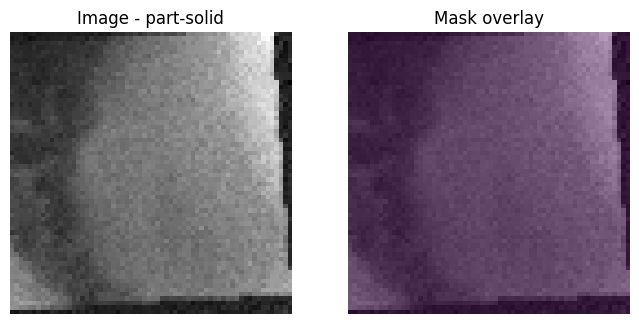


Sample 2: part-solid
Image: preprocessed_fleischner_fixed/augmented/part-solid/1.3.6.1.4.1.14519.5.2.1.6279.6001.226889213794065160713547677129_aug_0489.nii.gz
Mask:  preprocessed_fleischner_fixed/augmented/part-solid/1.3.6.1.4.1.14519.5.2.1.6279.6001.226889213794065160713547677129_aug_0489_mask.nii.gz


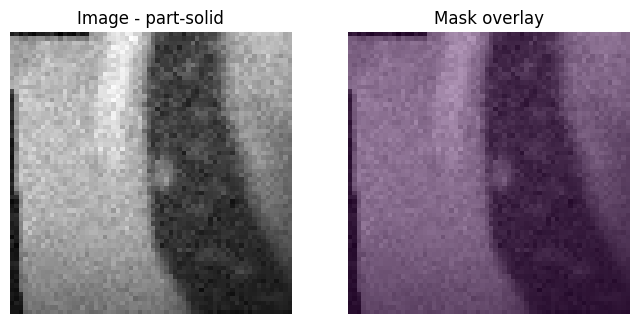


Sample 3: ground-glass
Image: preprocessed_fleischner_fixed/augmented/ground-glass/1.3.6.1.4.1.14519.5.2.1.6279.6001.154837327827713479309898027966_aug_0168.nii.gz
Mask:  preprocessed_fleischner_fixed/augmented/ground-glass/1.3.6.1.4.1.14519.5.2.1.6279.6001.154837327827713479309898027966_aug_0168_mask.nii.gz


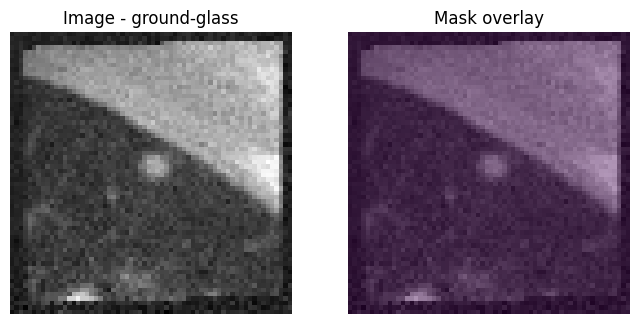


Sample 4: solid
Image: preprocessed_fleischner_fixed/augmented/solid/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732_aug_0160.nii.gz
Mask:  preprocessed_fleischner_fixed/augmented/solid/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732_aug_0160_mask.nii.gz


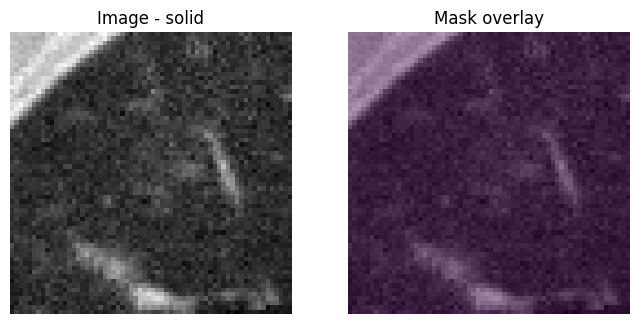


Sample 5: solid
Image: preprocessed_fleischner_fixed/augmented/solid/1.3.6.1.4.1.14519.5.2.1.6279.6001.826829446346820089862659555750_aug_0791.nii.gz
Mask:  preprocessed_fleischner_fixed/augmented/solid/1.3.6.1.4.1.14519.5.2.1.6279.6001.826829446346820089862659555750_aug_0791_mask.nii.gz


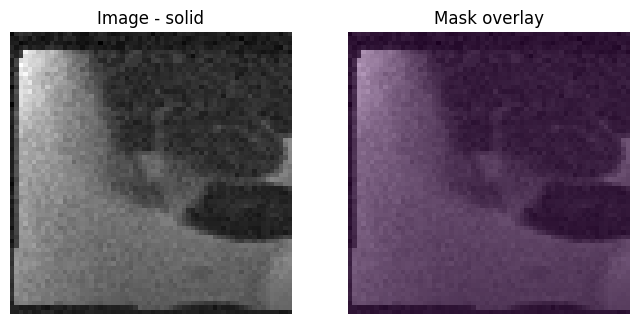

In [32]:
import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

AUG_DIR = "preprocessed_fleischner_fixed/augmented"
classes = ["ground-glass", "part-solid", "solid"]

# Collect all augmented sample paths
all_images = []
for cls in classes:
    class_dir = os.path.join(AUG_DIR, cls)
    for fname in os.listdir(class_dir):
        if fname.endswith(".nii.gz") and "_mask" not in fname and "_aug_" in fname:
            img_path = os.path.join(class_dir, fname)
            mask_path = img_path.replace(".nii.gz", "_mask.nii.gz")
            all_images.append((cls, img_path, mask_path))

print(f"Total augmented images found: {len(all_images)}")

# Pick 5 random images
samples = random.sample(all_images, 5)

for i, (cls, img_path, mask_path) in enumerate(samples):
    print(f"\nSample {i+1}: {cls}")
    print("Image:", img_path)
    print("Mask: ", mask_path)

    # Load volumes
    img = nib.load(img_path).get_fdata()
    mask = nib.load(mask_path).get_fdata()

    # Select central slice
    z = img.shape[2] // 2
    
    img_slice = img[:, :, z]
    mask_slice = mask[:, :, z]

    # Plot
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title(f"Image - {cls}")
    plt.imshow(img_slice, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Mask overlay")
    plt.imshow(img_slice, cmap='gray')
    plt.imshow(mask_slice, alpha=0.4)   # overlay
    plt.axis('off')

    plt.show()
